In [216]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import json
import requests

QUOTES_URL = 'https://iss.moex.com/iss/history/engines/stock/markets/shares/boards/TQBR/securities/{security}.json' \
                  '?from={start}&till={end}&iss.meta=off'

DIVIDENDS_URL = 'https://iss.moex.com/iss/securities/{security}/dividends.json?iss.meta=off'

def retrieve_quotes(security, start, end):
    url = QUOTES_URL.format(
    security = security,
    start = start,
    end = end)
    r = requests.get(url)
    data = pd.read_json(json.dumps(r.json()['history']), orient = 'split', typ = 'frame')
    data['TRADEDATE'] = data['TRADEDATE'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    return data

def retrieve_dividends(security):
    url = DIVIDENDS_URL.format(security = security)
    r = requests.get(url)
    data = pd.read_json(json.dumps(r.json()['dividends']), orient = 'split', typ = 'frame')
    data['registryclosedate'] = data['registryclosedate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    return data

def merge_quotes(security, start, end):
    dt_start = datetime.strptime(start, '%Y-%m-%d')
    dt_end = datetime.strptime(end, '%Y-%m-%d')
    quotes = retrieve_quotes(security, start, end)
    last = quotes['TRADEDATE'].to_list()[-1]
    while (dt_end - last).days > 5:
        dt_start = last + timedelta(days = 1)
        start = datetime.strftime(dt_start, '%Y-%m-%d')
        tmp = retrieve_quotes(security, start, end)
        quotes = pd.concat([quotes, tmp])
        last = quotes['TRADEDATE'].to_list()[-1]
    return quotes

def validate_dividends(divs, quotes):
    new_vals = []
    for i in range(len(divs)):
        date = divs.iloc[i]['registryclosedate']
        tmp = quotes.loc[date - timedelta(days = 5): date + timedelta(days = 5)]
        pre_div = tmp.loc[:date - timedelta(days = 2)].iloc[-1]['HIGH']
        post_div = tmp.loc[date - timedelta(days = 1):].iloc[0]['LOW']
        if (pre_div - post_div) < (divs.iloc[i]['value'] / 2):
            new_vals.append(0)
        else:
            new_vals.append(divs.iloc[i]['value'])
    divs['value'] = new_vals
    
def calculate_adjusted_prices(divs, quotes):
    

In [217]:
divs = retrieve_dividends('GAZP')

In [189]:
data = merge_quotes('GAZP', '2014-01-01', '2023-08-10')

data.reset_index(inplace = True)

data.drop(columns = ['index'], inplace = True)

data.set_index('TRADEDATE', inplace = True)

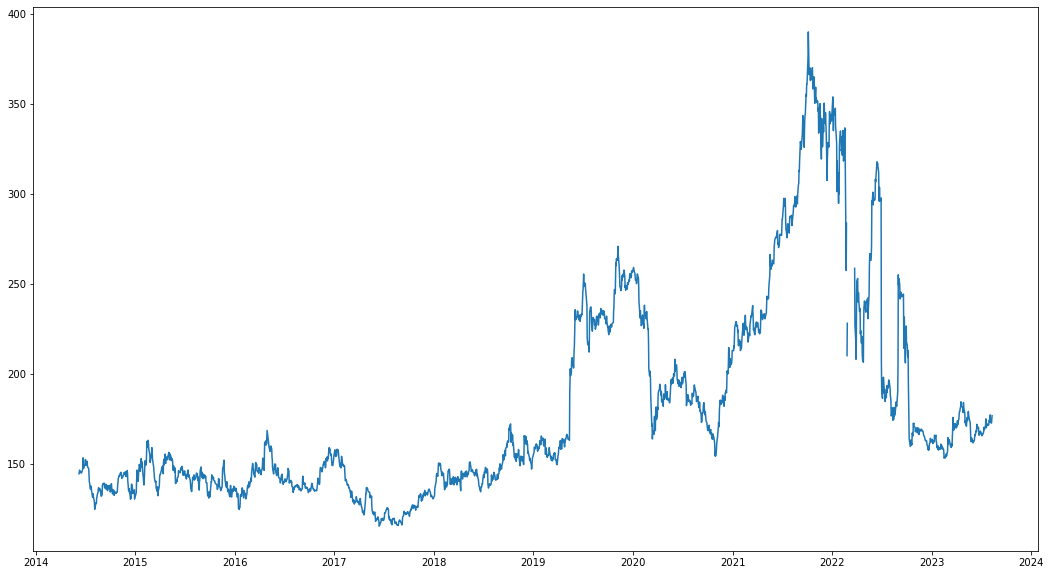

In [180]:
import matplotlib.pylab as plt

fig = plt.figure(figsize = (18, 10))

plt.plot(data['TRADEDATE'], data['CLOSE'])

plt.show()

In [218]:
validate_dividends(divs, data)

In [219]:
divs

,secid,isin,registryclosedate,value,currencyid
0,GAZP,RU0007661625,2014-07-17,7.20,RUB
1,GAZP,RU0007661625,2015-07-16,7.20,RUB
2,GAZP,RU0007661625,2016-07-20,7.89,RUB
3,GAZP,RU0007661625,2017-07-20,8.04,RUB
4,GAZP,RU0007661625,2018-07-19,8.04,RUB
5,GAZP,RU0007661625,2019-07-18,16.61,RUB
6,GAZP,RU0007661625,2020-07-16,15.24,RUB
7,GAZP,RU0007661625,2021-07-15,12.55,RUB
8,GAZP,RU0007661625,2022-07-20,0.00,RUB
9,GAZP,RU0007661625,2022-10-11,51.03,RUB


In [211]:
data.loc[datetime(2021, 4, 7): datetime(2021, 4, 9)]

,BOARDID,SHORTNAME,SECID,NUMTRADES,VALUE,OPEN,LOW,HIGH,LEGALCLOSEPRICE,WAPRICE,...,MARKETPRICE2,MARKETPRICE3,ADMITTEDQUOTE,MP2VALTRD,MARKETPRICE3TRADESVALUE,ADMITTEDVALUE,WAVAL,TRADINGSESSION,CURRENCYID,TRENDCLSPR
TRADEDATE,,,,,,,,,,,,,,,,,,,,,
2021-04-07,TQBR,ГАЗПРОМ ао,GAZP,55554,6.611799e+09,222.31,220.68,226.01,224.27,224.06,...,224.05,224.05,224.27,6.393566e+09,6.393566e+09,6.393566e+09,0.0,3,SUR,0.70
2021-04-08,TQBR,ГАЗПРОМ ао,GAZP,36373,4.359230e+09,224.84,222.88,226.30,223.95,224.43,...,224.47,224.47,223.95,4.079779e+09,4.079779e+09,4.079779e+09,0.0,3,SUR,-0.09
2021-04-09,TQBR,ГАЗПРОМ ао,GAZP,43206,4.653263e+09,224.20,221.48,224.30,221.70,222.48,...,222.49,222.49,221.70,4.421671e+09,4.421671e+09,4.421671e+09,0.0,3,SUR,-0.96
